<a href="https://colab.research.google.com/github/esfandiaryfard/machine-learning/blob/main/3d_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.backends.cudnn as cudnn
import PIL.Image
import os
import IPython.display
import numpy as np
from tqdm.notebook import tqdm
from google.colab import drive
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils import data
import io
import scipy.io 
import scipy.ndimage as nd

In [2]:
drive = drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def showarray(a, fmt='png'):
    a = (a - a.min())
    a = a /a.max()
    a = np.uint8(a*255)
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

In [4]:
# Set parameters
outf = "output"
batch_size = 32
num_workers = 2
image_size = 32
nz = 200 # Length of the noise vector
ngf = 32 # Initial generator feature maps
ndf = 64 # Initial discriminator feature maps
num_epochs = 500
d_lr = 0.00001
g_lr = 0.0025
beta = (0.5, 0.999)
saveCheck = 1 # Save checkpoint every # epochs
in_channels = 200 #512
in_dim = 1
cube_len = 32
dsets_path = "drive/MyDrive/volumetric_data/chair/30/train/"

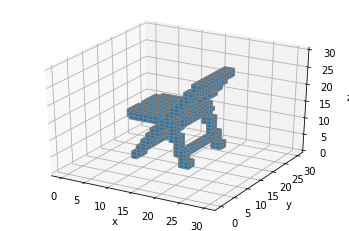

In [5]:
data = scipy.io.loadmat(dsets_path + 'chair_000000182_1.mat')

data = data['instance']



from mpl_toolkits.mplot3d import Axes3D
def make_ax(grid=False):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.grid(grid)
    return ax

ax = make_ax(True)
ax.voxels(data, edgecolors='gray', shade=False)
plt.show()



In [6]:
try:
    os.makedirs(outf)
except OSError:
  pass   

In [7]:
cudnn.benchmark = True

In [8]:
# Setup device
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(dev)

cpu


In [9]:
model_save_step = 1
leak_value = 0.2
bias = False

In [10]:

'''
utils.py

Some utility functions

'''

import scipy.ndimage as nd
import scipy.io as io
import matplotlib


if dev.type != 'cpu':
    matplotlib.use('Agg')

import matplotlib.pyplot as plt
import skimage.measure as sk
from mpl_toolkits import mplot3d
import matplotlib.gridspec as gridspec
import numpy as np
from torch.utils import data
from torch.autograd import Variable
import torch
import os
import pickle



def getVoxelFromMat(path, cube_len=64):
    if cube_len == 32:
        voxels = io.loadmat(path)['instance'] # 30x30x30
        voxels = np.pad(voxels, (1, 1), 'constant', constant_values=(0, 0))

    else:
        voxels = io.loadmat(path)['instance'] # 30x30x30
        voxels = np.pad(voxels, (1, 1), 'constant', constant_values=(0, 0))
        voxels = nd.zoom(voxels, (2, 2, 2), mode='constant', order=0)
    return voxels


def getVFByMarchingCubes(voxels, threshold=0.5):
    v, f = sk.marching_cubes_classic(voxels, level=threshold)
    return v, f


def plotVoxelVisdom(voxels, visdom, title):
    v, f = getVFByMarchingCubes(voxels)
    visdom.mesh(X=v, Y=f, opts=dict(opacity=0.5, title=title))


def SavePloat_Voxels(voxels, path, iteration):
    voxels = voxels[:8].__ge__(0.5)
    fig = plt.figure(figsize=(32, 16))
    gs = gridspec.GridSpec(2, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(voxels):
        x, y, z = sample.nonzero()
        ax = plt.subplot(gs[i], projection='3d')
        ax.scatter(x, y, z, zdir='z', c='red')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        # ax.set_aspect('equal')
    # print (path + '/{}.png'.format(str(iteration).zfill(3)))
    plt.savefig(path + '/{}.png'.format(str(iteration).zfill(3)), bbox_inches='tight')
    plt.close()


class ShapeNetDataset(data.Dataset):

    def __init__(self, root, train_or_val="train"):
        self.root = root
        self.listdir = os.listdir(self.root)
        data_size = len(self.listdir)
        self.listdir = self.listdir[0:int(data_size)]
        print ('data_size =', len(self.listdir)) # train: 10668-1000=9668
        

    def __getitem__(self, index):
        with open(self.root + self.listdir[index], "rb") as f:
            volume = np.asarray(getVoxelFromMat(f, cube_len), dtype=np.float32)
            # print (volume.shape)
        return torch.FloatTensor(volume)

    def __len__(self):
        return len(self.listdir)

In [11]:
dataset = ShapeNetDataset(dsets_path, "train")
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers = num_workers)
dset_len = {"train": len(dataset)}
dset_loaders = {"train": dataloader}

data_size = 10808


In [12]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1: # For every Conv Layer in a model
        # Initializes weights with values from a normal distribution
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [13]:
#Generator definition
class _netG(nn.Module):
    def __init__(self):
        super(_netG, self).__init__()
        self.cube_len = cube_len
        self.bias = bias
        self.z_dim = nz
        self.f_dim = 32

        padd = (0, 0, 0)
        if self.cube_len == 32:
            padd = (1,1,1)

        self.layer1 = self.conv_layer(self.z_dim, self.f_dim*8, kernel_size=4, stride=2, padding=padd, bias=self.bias)
        self.layer2 = self.conv_layer(self.f_dim*8, self.f_dim*4, kernel_size=4, stride=2, padding=(1, 1, 1), bias=self.bias)
        self.layer3 = self.conv_layer(self.f_dim*4, self.f_dim*2, kernel_size=4, stride=2, padding=(1, 1, 1), bias=self.bias)
        self.layer4 = self.conv_layer(self.f_dim*2, self.f_dim, kernel_size=4, stride=2, padding=(1, 1, 1), bias=self.bias)
        
        self.layer5 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.f_dim, 1, kernel_size=4, stride=2, bias=self.bias, padding=(1, 1, 1)),
            torch.nn.Sigmoid()
            # torch.nn.Tanh()
        )

    def conv_layer(self, input_dim, output_dim, kernel_size=4, stride=2, padding=(1,1,1), bias=False):
        layer = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(input_dim, output_dim, kernel_size=kernel_size, stride=stride, bias=bias, padding=padding),
            torch.nn.BatchNorm3d(output_dim),
            torch.nn.ReLU(True)
            # torch.nn.LeakyReLU(self.leak_value, True)
        )
        return layer

    def forward(self, x):
        out = x.view(-1, self.z_dim, 1, 1, 1)
        # print(out.size())  # torch.Size([32, 200, 1, 1, 1])
        out = self.layer1(out)
        # print(out.size())  # torch.Size([32, 256, 2, 2, 2])
        out = self.layer2(out)
        # print(out.size())  # torch.Size([32, 128, 4, 4, 4])
        out = self.layer3(out)
        # print(out.size())  # torch.Size([32, 64, 8, 8, 8])
        out = self.layer4(out)
        # print(out.size())  # torch.Size([32, 32, 16, 16, 16])
        out = self.layer5(out)
        # print(out.size())  # torch.Size([32, 1, 32, 32, 32])
        out = torch.squeeze(out)
        return out

In [14]:
# Create the Generator 
netG = _netG()
# Initialize weights
# netG.apply(weights_init)
print(netG)

_netG(
  (layer1): Sequential(
    (0): ConvTranspose3d(200, 256, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (1): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer2): Sequential(
    (0): ConvTranspose3d(256, 128, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer3): Sequential(
    (0): ConvTranspose3d(128, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer4): Sequential(
    (0): ConvTranspose3d(64, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inpl

In [15]:
#Discriminator definition
class _netD(nn.Module):
    def __init__(self):
        super(_netD, self).__init__()
        self.cube_len = cube_len
        self.leak_value = leak_value
        self.bias = bias

        padd = (0,0,0)
        if self.cube_len == 32:
            padd = (1,1,1)

        self.f_dim = 32

        self.layer1 = self.conv_layer(1, self.f_dim, kernel_size=4, stride=2, padding=(1,1,1), bias=self.bias)
        self.layer2 = self.conv_layer(self.f_dim, self.f_dim*2, kernel_size=4, stride=2, padding=(1,1,1), bias=self.bias)
        self.layer3 = self.conv_layer(self.f_dim*2, self.f_dim*4, kernel_size=4, stride=2, padding=(1,1,1), bias=self.bias)
        self.layer4 = self.conv_layer(self.f_dim*4, self.f_dim*8, kernel_size=4, stride=2, padding=(1,1,1), bias=self.bias)

        self.layer5 = torch.nn.Sequential(
            torch.nn.Conv3d(self.f_dim*8, 1, kernel_size=4, stride=2, bias=self.bias, padding=padd),
            torch.nn.Sigmoid()
        )

        # self.layer5 = torch.nn.Sequential(
        #     torch.nn.Linear(256*2*2*2, 1),
        #     torch.nn.Sigmoid()
        # )

    def conv_layer(self, input_dim, output_dim, kernel_size=4, stride=2, padding=(1,1,1), bias=False):
        layer = torch.nn.Sequential(
            torch.nn.Conv3d(input_dim, output_dim, kernel_size=kernel_size, stride=stride, bias=bias, padding=padding),
            torch.nn.BatchNorm3d(output_dim),
            torch.nn.LeakyReLU(self.leak_value, inplace=True)
        )
        return layer

    def forward(self, x):
        # out = torch.unsqueeze(x, dim=1)
        out = x.view(-1, 1, self.cube_len, self.cube_len, self.cube_len)
        # print(out.size()) # torch.Size([32, 1, 32, 32, 32])
        out = self.layer1(out)
        # print(out.size())  # torch.Size([32, 32, 16, 16, 16])
        out = self.layer2(out)
        # print(out.size())  # torch.Size([32, 64, 8, 8, 8])
        out = self.layer3(out)
        # print(out.size())  # torch.Size([32, 128, 4, 4, 4])
        out = self.layer4(out)
        # print(out.size())  # torch.Size([32, 256, 2, 2, 2])
        # out = out.view(-1, 256*2*2*2)
        # print (out.size())
        out = self.layer5(out)
        # print(out.size())  # torch.Size([32, 1, 1, 1, 1])
        out = torch.squeeze(out)
        return out

In [16]:
# Create the Discriminator
netD = _netD()
# Initialize weights
# netD.apply(weights_init)
print(netD)

_netD(
  (layer1): Sequential(
    (0): Conv3d(1, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer2): Sequential(
    (0): Conv3d(32, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer3): Sequential(
    (0): Conv3d(64, 128, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer4): Sequential(
    (0): Conv3d(128, 256, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (1): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_ru

In [17]:
# Define a Loss
criterion_D = nn.MSELoss()
criterion_G = nn.L1Loss()

In [18]:
# Define optimizers
optimizerD = optim.Adam(netD.parameters(), lr=d_lr, betas=beta)
optimizerG = optim.Adam(netG.parameters(), lr=g_lr, betas=beta)

In [19]:
# A batch of latent vectors; we will use it to visualize the progression of the generator
fixed_noise = torch.FloatTensor(batch_size, nz, 1, 1).normal_(0, 1).to(dev)

real_label = 1
fake_label = 0

In [20]:
# Move to cuda
netD.to(dev)
netG.to(dev) 

_netG(
  (layer1): Sequential(
    (0): ConvTranspose3d(200, 256, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (1): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer2): Sequential(
    (0): ConvTranspose3d(256, 128, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer3): Sequential(
    (0): ConvTranspose3d(128, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer4): Sequential(
    (0): ConvTranspose3d(64, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inpl

In [21]:
# !pip install pytorch-fid

In [22]:
# dataset_fid= Minst3D('Medical/AbdomenCT/', transform=transforms.Compose([
#                            transforms.Resize(image_size)
#                        ] ) )

# os.makedirs('medical')
# for idx in tqdm(range(len(dataset_fid))):
#   img, label = dataset_fid.__getitem__(idx)
#   img.save(f"medical/{idx}.png")

In [23]:
# from pytorch_fid.fid_score import calculate_fid_given_paths
# import uuid
# import shutil

In [24]:
# import matplotlib
# matplotlib.pyplot.plot(all_fid)

In [25]:
! pip install tensorboardX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 4.8 MB/s 


In [26]:
'''
trainer.py

Train 3dgan models
'''

import torch
from torch import optim
from torch import nn

import os



# added
import datetime
import time
from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm


def save_train_log(writer, loss_D, loss_G, itr):
    scalar_info = {}
    for key, value in loss_G.items():
        scalar_info['train_loss_G/' + key] = value

    for key, value in loss_D.items():
        scalar_info['train_loss_D/' + key] = value

    for tag, value in scalar_info.items():
        writer.add_scalar(tag, value, itr)


def save_val_log(writer, loss_D, loss_G, itr):
    scalar_info = {}
    for key, value in loss_G.items():
        scalar_info['val_loss_G/' + key] = value

    for key, value in loss_D.items():
        scalar_info['val_loss_D/' + key] = value

    for tag, value in scalar_info.items():
        writer.add_scalar(tag, value, itr)


def trainer():
    netD.train()
    netG.train()
    for epoch in range(num_epochs):
        start = time.time()
        running_loss_G = 0.0
        running_loss_D = 0.0
        running_loss_adv_G = 0.0

        for i, data in enumerate(tqdm(dataloader)):
            netD.zero_grad()
            X = data.to(dev)
            batch = X.size()[0]
            Z = torch.Tensor(batch, nz).normal_(0, 0.33).to(dev)
            output = netD(X)
            real_labels = torch.ones_like(output).to(dev)
            errD_real = criterion_D(output, real_labels)
            fake = netG(Z)
            d_fake = netD(fake) 
            fake_labels = torch.zeros_like(d_fake).to(dev)
            d_fake_loss = criterion_D(d_fake, fake_labels)
            d_loss = errD_real + d_fake_loss
            netD.zero_grad()
            d_loss.backward()
            optimizerD.step()
            # =============== Train the generator ===============#
            Z = torch.Tensor(batch, nz).normal_(0, 0.33).to(dev)
            fake = netG(Z)  # generated fake: 0-1, X: 0/1
            d_fake = netD(fake)
            adv_g_loss = criterion_D(d_fake, real_labels)
            recon_g_loss = criterion_G(fake, X)
            g_loss = adv_g_loss
            netG.zero_grad()
            g_loss.backward()
            optimizerG.step()



      # # Print
      # avg_d_real_loss = sum_d_real_loss/num_d_real_loss
      # avg_d_fake_loss = sum_d_fake_loss/num_d_fake_loss
      # avg_g_loss = sum_g_loss/num_g_loss
      # #FID
      # # os.makedirs('tmp')
      # for _ in tqdm(range(20)):
      #   with torch.no_grad():
      #     noise = torch.randn(1, nz, device=dev)
      #     fake_imgs = netG(noise)
      #   for idx in range(fake_imgs.shape[0]):
      #     fake_img = fake_imgs[idx]
      #     # vutils.save_image(fake_img,f"tmp/{str(uuid.uuid4())}.png",normalize=True)

      # # fid = calculate_fid_given_paths(['medical','tmp'],dims=2048, device = 'cuda',batch_size=64)
      # # all_fid.append(fid)
      # # shutil.rmtree('tmp')
      # # print(f"Epoch {epoch}: FID={fid:.4f} DR={avg_d_real_loss:.4f}, DF={avg_d_fake_loss:.4f}, G={avg_g_loss:.4f}")


      # # do checkpointing
      # if epoch % saveCheck == 0:
      #     torch.save(netG.state_dict(), '%s/netG_epoch_%d.pth' % (outf, epoch))
      #     torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (outf, epoch))




        #---------------------------new-----------------------------------------


            # =============== logging each 10 iterations ===============#

            running_loss_G += recon_g_loss.item() * X.size(0)
            running_loss_D += d_loss.item() * X.size(0)
            running_loss_adv_G += adv_g_loss.item() * X.size(0)

            
        # =============== each epoch save model or save image ===============#
        epoch_loss_G = running_loss_G / len(dataset)
        epoch_loss_D = running_loss_D / len(dataset)
        epoch_loss_adv_G = running_loss_adv_G / len(dataset)

        end = time.time()
        epoch_time = end - start

        print('Epochs-{} ({}) , D(x) : {:.4}, D(G(x)) : {:.4}'.format(epoch, 'train', epoch_loss_D, epoch_loss_adv_G))
        print('Elapsed Time: {:.4} min'.format(epoch_time / 60.0))

        # os.mkdir("output")
        model_saved_path = outf
        

        if (epoch + 1) % model_save_step == 0:
            print('model_saved, images_saved...')
            torch.save(netG.state_dict(), model_saved_path + '/G.pth')
            torch.save(netD.state_dict(), model_saved_path + '/D.pth')

            samples = fake.cpu().data[:8].squeeze().numpy()
            # print (samples.shape)
            # image_saved_path = '../images'

            SavePloat_Voxels(samples, model_saved_path, epoch)

In [27]:
trainer()

 31%|███       | 104/338 [13:54<31:16,  8.02s/it]


KeyboardInterrupt: ignored